In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


텐서플로우를 이용해서 MNIST 데이터를 분류하는 다층 퍼셉트론을 구현한다.

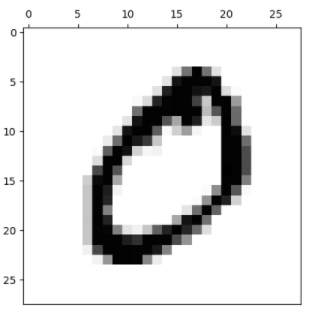

In [3]:
from IPython.display import Image
Image('MNIST.png', width='500')

In [4]:
# MNIST 손글씨 실습을 위해 케라스에서 제공하는 MNIST 데이터 셋을 사용한다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 학습 데이터에는 총 60,000개의 샘플이 있고 테스트 데이터에는 총 10,000개의 샘플이 있다.
# MNIST 데이터는 28개의 행과 28개의 열을 갖는 필셀 데이터이다. 각 픽셀은 흑백 사진과 같이 0부터 255까지의 그레이스케일을
# 가지고 있다.
print(x_train.shape, y_train.shape) # 학습 데이터
print(x_test.shape, y_test.shape)   # 학습이 완료된 후 테스트 데이터

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


학습 데이터를 학습 데이터(5만개)와 검증 데이터(1만개)를 분리한다.  
학습 중간마다 검증 데이터로 모델의 성능을 측정하면 모델 학습이 제대로 진행되는지 검증 정확도를 알 수 있고 학습 정확도는 올라가는데 검증 정확도가 안 올라가거나 떨어질 경우 조기 종료를 구현할 수 있다.

In [5]:
x_val = x_train[50000:]   # 28행 28열로 구성된 검증 데이터
x_train = x_train[:50000] # 28행 28열로 구성된 학습 데이터
y_val = y_train[50000:]   # 검증 데이터 실제값
y_train = y_train[:50000] # 학습 데이터 실제값

In [6]:
# 학습 데이터를 출력해보면 데이터가 0부터 255까지의 숫자(그레이스케일)로 구성된 것을 확인할 수 있다.
print(y_train[:10])
for i in x_train[1]:
    for j in i:
        print('%3d ' % j, end='')
    print()

[5 0 4 1 9 2 1 3 1 4]
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  9

MNIST 데이터를 불러왔으니 다층 퍼셉트론의 입력값으로 들어갈 수 있도록 numpy의 reshape 함수를 사용해 2차원 형태의 데이터를 1원 배열 형태로 변경한다.

In [7]:
# 28 * 28 픽셀의 단색 이미지이므로 데이터 형태를 784개의 1차원 배열 형태로 변환한다.
import numpy as np
x_train = np.reshape(x_train, (50000, 784)) # 28행 28열로 구성된 학습 데이터를 784개의 1차원 배열 형태로 변환한다.
print('x_train.shape: {}'.format(x_train.shape))
x_val = x_val.reshape(10000, 784)           # 28행 28열로 구성된 검증 데이터를 784개의 1차원 배열 형태로 변환한다.
print('x_val.shape: {}'.format(x_val.shape))
x_test = x_test.reshape(10000, 784)         # 28행 28열로 구성된 테스트 데이터를 784개의 1차원 배열 형태로 변환한다.
print('x_test.shape: {}'.format(x_test.shape))

x_train.shape: (50000, 784)
x_val.shape: (10000, 784)
x_test.shape: (10000, 784)


1차원으로 변경된 데이터를 그대로 다층 퍼셉트론에 입력해도 되지만 좀 더 효율적인 학습을 위해 데이터를 정규화 시킨다.  
정규화는 모델의 학습 시간을 단축시키고 더 나은 성능을 보이게 하는 효과가 있다.
MNIST 데이터의 모든 값은 0부터 255까지의 범위 안에 있으므로 255로 나눠 모든 값을 0부터 1사이의 값으로 정규화 한다.

In [8]:
# print(type(x_train[0][0]), x_train[0][0])
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
gray_scale = 255
x_train /= gray_scale
# print(type(x_train[0][0]), x_train[0][0])
x_val /= gray_scale
x_test /= gray_scale

MNIST 손글씨 데이터 분류 모델은 0부터 9까지의 숫자로 분류하는 다중 모델이므로 손실 함수로 크로스 엔트로피를 사용한다.  
크로스 엔트로피를 계산하기 위해 실제값(y)은 원 핫 인코딩으로 변환한다.  
원 핫 인코딩(One Hot Encoding)은 데이터를 수많은 0과 1개의 1값으로 데이터를 구별하는 인코딩 방식으로 0으로 이루어진 벡터 집합에 단 1개의 1의 값으로 해당 데이터를 구별하는 것을 말한다.

In [9]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
# print(y_train[:5]) => [5 0 4 1 9]
for i in y_train[:5]:
    print(i)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


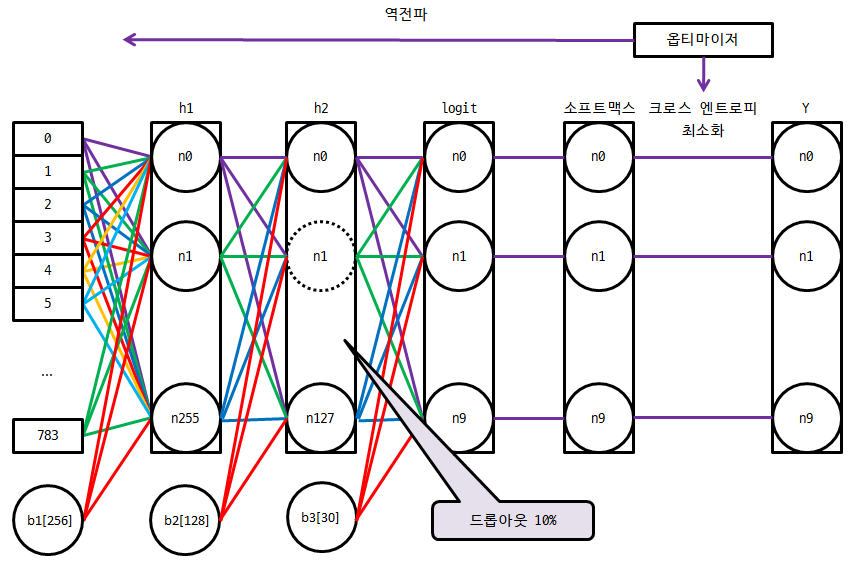

In [11]:
from IPython.display import Image
Image('MNIST2.png', width='900')

입력 데이터는 784개의 숫자가 들어있는 배열이다.  
784개의 입력을 받는 256개의 노드가 1번째 레이어에 있고 1번째 레이어의 출력값을 입력으로 받는 2번째 레이어에는 128개의 노드가 있다. 2번째 레이어에 10% 드롭아웃을 적용하고 2번째 레이어의 출력을 받는 3번째 레이어에는 총 10개의 노드가 존재하며 이 10개의 노드값은 소프트맥스를 통과해서 0부터 9까지에 해당하는 각 숫자의 확률을 의미하게 된다.  
소프트맥스 출력값과 실제값의 차이를 계산하기 위해 크로스 엔트로피를 손실 함수로 사용하고 손실 함수를 최소화하기 위해 Adam 옵티마이저를 사용해 역전파를 통해 모든 가중치 및 편향값을 최적화한다.  
최적화 함수 참고 : https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam
***
소프트맥스는 분류해야하는 정답지(클래스)의 총 개수를 k라고 할 때 k차원의 벡터를 입력받아 각 클래스에 대한 확률을 추정한다.

In [12]:
# 1번째 차원이 None인 이유는 데이터 개수 제약없이 입력받기 위해서이고 2번째 차원이 784인 것은 MNIST의 이미지 크기가 28 * 28
# 픽셀 = 784 픽셀이기 때문이다.
x = tf.placeholder(tf.float32, [None, 784]) # 입력값
y = tf.placeholder(tf.float32, [None, 10])  # 출력값
keep_prob = tf.placeholder(tf.float32)      # 드롭아웃 적용 변수

다층 퍼셉트론을 구현한다.

In [13]:
# 다층 퍼셉트론을 구현한 함수
def mlp(x):
    # 히든 레이어1
    w1 = tf.Variable(tf.random_uniform([784, 256]))
    b1 = tf.Variable(tf.zeros([256]))
    h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
    # 히든 레이어2
    w2 = tf.Variable(tf.random_uniform([256, 128]))
    b2 = tf.Variable(tf.zeros([128]))
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    # 드롭아웃 적용, keep_prob만 썼었는데 버전이 올라가면서 rate=1-keep_prob 형태로 써야한다.
    h2_drop = tf.nn.dropout(h2, rate=1-keep_prob)
    # 히든 레이어3
    w3 = tf.Variable(tf.random_uniform([128, 10]))
    b3 = tf.Variable(tf.zeros([10]))
    logits = tf.nn.relu(tf.matmul(h2_drop, w3) + b3)
    return logits

In [14]:
# 다층 퍼셉트론의 출력값을 logits로 정의한다.
# logit => logistic과 probit의 합성어로 probit은 확률을 재는 단위라는 뜻이다.
logits = mlp(x)
# logits와 실제값의 크로스 엔트로피를 손실 함수로 사용한다.
# 크로스 엔트로피 함수 공식 tf.reduce_mean(-tf.reduce_sum(y * tf.log(tf.nn.softmax(logits)), reduction_indices=1))을 그대로
# 사용하면 수치적으로 불안정하여 계산 오류가 발생할 수 있으므로
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
# Adam 옵티마이저를 사용해 모델을 최적화한다. 모델의 최적화 과정은 모델의 예측값과 실제값의 차이를 줄여나가는 과정을 의미한다.
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_op)

조기 종료는 과대적합을 피하고 충분한 학습을 하기 위해 학습 중간마다 검증 데이터에 대한 정확도를 측정해 학습 정확도는 계속 증가하는 반면 검증 데이터에 대한 정확도가 점차 떨어질 경우 중지하는 것을 말한다.  
매 주기(epoch)마다 검증 데이터로 검증 정확도를 측정한다. 검증 정확도가 5번 연속으로 최고 검증 정확도 보다 높지 않을 경우 조기 종료를 수행한다.

In [15]:
init = tf.global_variables_initializer() # 텐서플로우 변수 초기화
saver = tf.train.Saver()                 # 텐서플로우 모델의 저장 및 로드에 사용할 변수를 선언한다.
epoch_cnt = 300                          # 조기 종료가 일어나지 않을 경우 최대 300번까지 반복해서 학습하도록 설정한다.
batch_size = 1000                        # 1번에 처리할 데이터의 개수를 설정한다.
iteration = len(x_train) // batch_size   # batch_size에 따른 학습 반복 횟수를 설정한다.
earlystop_threshold = 5                  # 검증 정확도가 최고 정확도보다 5번 연속으로 높지 않을 경우 조기 종료하도록 설정한다.
earlystop_cnt = 0                        # 검증 정확도가 최고 정확도보다 연속으로 높지 않은 횟수를 세는 변수를 선언한다.

학습을 진행한다.  
데이터를 모델에 입력할 때 모델에 드롭아웃이 적용된 경우 항상 keep_prob을 설정해야 한다. 학습 시 10%의 드롭아웃을 적용하기 위해 keep_drop을 0.9로 설정하고 테스트할 때는 드롭아웃을 적용하지 않을 겻이므로 keep_prob을 1.0으로 설정한다.

In [16]:
a = tf.constant([3, 10, 1]) # 1차원 배열
sess = tf.Session()
# tf.argmax() 메소드는 배열에서 가장 큰 값을 찾아서 그 인덱스를 리턴한다.
# a 배열에서 10이 가장 크기 때문에 결과는 10의 인덱스인 1이 출력된다.
print(sess.run(tf.argmax(a, 0)))

b = tf.constant([[3, 10, 1], [4, 5, 6], [0, 8, 7]]) # 2차원 배열
# tf.argmax() 메소드를 2차원 배열에서 실행할 때 2번째 인수로 0을 지정하면 각 열에서 가장 큰 값을 찾아 그 인덱스를 리턴한다.
print(sess.run(tf.argmax(b, 0)))
# tf.argmax() 메소드를 2차원 배열에서 실행할 때 2번째 인수로 1을 지정하면 각 행에서 가장 큰 값을 찾아 그 인덱스를 리턴한다.
print(sess.run(tf.argmax(b, 1)))

1
[1 0 2]
[1 2 1]


학습을 진행한다.

In [18]:
with tf.Session() as sess:
    sess.run(init)       # 텐서플로우 변수 초기화
    prev_train_acc = 0.0 # 이전 학습 정확도를 기억하는 변수를 선언한다.
    max_val_acc = 0.0    # 검증 정확도의 최대값을 기억하는 변수를 선언한다.
    # 지정된 최대 epoch 만큼 학습한다. => 검증 정확도가 최고 정확도보다 5번 연속으로 높지 않을 경우 학습을 조기 종료한다.
    for epoch in range(epoch_cnt):
        avg_loss = 0.0   # 손실값
        start = 0        # 학습 시작 위치
        end = batch_size # 학습 끝 위치
        # 학습 데이터를 batch_size 개씩 나눠 학습을 진행한다.
        for i in range(iteration):
            _, loss = sess.run([train_op, loss_op], feed_dict={x: x_train[start:end], y: y_train[start:end], keep_prob: 0.9})
            start += batch_size
            end += batch_size
            # 크로스 엔트로피 손실 함수의 학습 손실값을 계산한다.
            avg_loss += loss / iteration
        # ============================================

        # 모델 검증
        preds = tf.nn.softmax(logits) # 소프트맥스 적용
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
        
        # 정확도 계산
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        # 학습 정확도 계산
        # Session.run()과 Tensor.eval()의 차이
        # t가 Tensor 오브젝트라면 t.eval()은 sess.run(t)의 속기 표현이다.(sess가 현재 디폴트 세션인 곳에서만)
        cur_train_acc = accuracy.eval({x: x_train, y: y_train, keep_prob: 1.0})
        # 검증 정확도 계산
        cur_val_acc = accuracy.eval({x: x_val, y: y_val, keep_prob: 1.0})
        # 검증 데이터에 대한 손실값 계산
        cur_val_loss = loss_op.eval({x: x_val, y: y_val, keep_prob: 1.0})
        # 학습 정확도와 검증 정확도를 출력한다.
        print('epoch: {0:3d}, 학습 정확도: {1:7.5f}, 검증 정확도: {2:7.5f}'.format(epoch, cur_train_acc, cur_val_acc))
        
        # 현재 검증 정확도와 검증 정확도의 최대값을 비교한다.
        if cur_val_acc < max_val_acc:
            # 현재 검증 정확도가 검증 정확도의 최대값 미만이면
            # 현재 학습 정확도와 이전 학습 정확도, 현재 학습 정확도와 0.99를 비교한다.
            if cur_train_acc > prev_train_acc or cur_train_acc > 0.99:
                # 현재 학습 정확도가 이전 학습 정확도 보다 크거나 현재 학습 정확도가 0.99 보다 크면
                if earlystop_cnt == earlystop_threshold:
                    # 5번 연속으로 현재 학습 정확도가 이전 학습 정확도 보다 크면 조기 종료한다.
                    print('조기 종료 시점: {}'.format(epoch))
                    break
                else:
                    # 5번 연속으로 현재 학습 정확도가 이전 학습 정확도 보다 크지 않다면 이전 학습 정확도가 현재 학습 정확도
                    # 보다 크므로 현재 검증 정확도가 최고 정확도의 최대값보다 연속으로 높지 않은 횟수를 카운트 하는 변수를
                    # 1증가 시킨다.
                    print('과대적합 경고 횟수: {}'.format(earlystop_cnt))
                    earlystop_cnt += 1
                # ============================================
            else:
                # 현재 학습 정확도가 이전 학습 정확도 보다 작거나, 현재 학습 정확도가 0.99 이하이면
                # 이전 학습 정확도가 현재 학습 정확도 이상이므로 현재 검증 정확도가 정확도의 최대값 보다 연속으로 높지 않은
                # 횟수를 카운트하는 변수를 다시 0으로 초기화시킨다.
                earlystop_cnt = 0
            # ============================================
        else:
            # 현재 검증 정확도가 검증 정확도의 최대값 이상이면
            # 현재 검증 정확도가 검증 정확도의 최대값 보다 연속으로 높지 않은 횟수를 카운트 하는 변수를 다시 0으로 초기화
            # 시킨다.
            earlystop_cnt = 0
            # 검증 정확도의 최대값을 현재 검증 정확도로 교체한다.
            max_val_acc = cur_val_acc
            # 검증 정확도가 가장 높은 모델을 저장한다.
            save_path = saver.save(sess, './model/model.ckpt')
        # ============================================
        # 다음 학습을 위해 현재 학습 정확도를 이전 학습 정확도를 기억하는 변수에 넣어준다.
        prev_train_acc = cur_train_acc
    # ============================================

epoch:   0, 학습 정확도: 0.16106, 검증 정확도: 0.16630
epoch:   1, 학습 정확도: 0.48968, 검증 정확도: 0.50700
epoch:   2, 학습 정확도: 0.59078, 검증 정확도: 0.62080
epoch:   3, 학습 정확도: 0.64636, 검증 정확도: 0.67050
epoch:   4, 학습 정확도: 0.69610, 검증 정확도: 0.71870
epoch:   5, 학습 정확도: 0.73486, 검증 정확도: 0.75910
epoch:   6, 학습 정확도: 0.76092, 검증 정확도: 0.77850
epoch:   7, 학습 정확도: 0.78432, 검증 정확도: 0.80080
epoch:   8, 학습 정확도: 0.79930, 검증 정확도: 0.81340
epoch:   9, 학습 정확도: 0.81630, 검증 정확도: 0.82990
epoch:  10, 학습 정확도: 0.82960, 검증 정확도: 0.84200
epoch:  11, 학습 정확도: 0.84064, 검증 정확도: 0.85090
epoch:  12, 학습 정확도: 0.85086, 검증 정확도: 0.85910
epoch:  13, 학습 정확도: 0.86028, 검증 정확도: 0.86620
epoch:  14, 학습 정확도: 0.86810, 검증 정확도: 0.87220
epoch:  15, 학습 정확도: 0.87376, 검증 정확도: 0.87760
epoch:  16, 학습 정확도: 0.88062, 검증 정확도: 0.88320
epoch:  17, 학습 정확도: 0.88670, 검증 정확도: 0.88860
epoch:  18, 학습 정확도: 0.89188, 검증 정확도: 0.89300
epoch:  19, 학습 정확도: 0.89632, 검증 정확도: 0.89600
epoch:  20, 학습 정확도: 0.90046, 검증 정확도: 0.89950
epoch:  21, 학습 정확도: 0.90288, 검증 정확도: 0.90280
epoch:  22

epoch: 167, 학습 정확도: 0.98716, 검증 정확도: 0.95680
epoch: 168, 학습 정확도: 0.98722, 검증 정확도: 0.95600
과대적합 경고 횟수: 0
epoch: 169, 학습 정확도: 0.98782, 검증 정확도: 0.95690
epoch: 170, 학습 정확도: 0.98896, 검증 정확도: 0.95570
과대적합 경고 횟수: 0
epoch: 171, 학습 정확도: 0.98686, 검증 정확도: 0.95560
epoch: 172, 학습 정확도: 0.98530, 검증 정확도: 0.95230
epoch: 173, 학습 정확도: 0.98434, 검증 정확도: 0.95360
epoch: 174, 학습 정확도: 0.98556, 검증 정확도: 0.95270
과대적합 경고 횟수: 0
epoch: 175, 학습 정확도: 0.98686, 검증 정확도: 0.95640
과대적합 경고 횟수: 1
epoch: 176, 학습 정확도: 0.98766, 검증 정확도: 0.95570
과대적합 경고 횟수: 2
epoch: 177, 학습 정확도: 0.98632, 검증 정확도: 0.95460
epoch: 178, 학습 정확도: 0.98870, 검증 정확도: 0.95570
과대적합 경고 횟수: 0
epoch: 179, 학습 정확도: 0.98604, 검증 정확도: 0.95460
epoch: 180, 학습 정확도: 0.98838, 검증 정확도: 0.95390
과대적합 경고 횟수: 0
epoch: 181, 학습 정확도: 0.98684, 검증 정확도: 0.95590
epoch: 182, 학습 정확도: 0.98778, 검증 정확도: 0.95510
과대적합 경고 횟수: 0
epoch: 183, 학습 정확도: 0.99008, 검증 정확도: 0.95640
과대적합 경고 횟수: 1
epoch: 184, 학습 정확도: 0.99050, 검증 정확도: 0.95780
epoch: 185, 학습 정확도: 0.99046, 검증 정확도: 0.95910
epoch: 186, 학습 정확도:

테스트

In [21]:
with tf.Session() as sess:
    # 검증 결과가 가장 높았던 모델을 불러온다.
    saver.restore(sess, './model/model.ckpt')
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1))
    # 정확도 계산
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print('정확도: {}'.format(accuracy.eval({x: x_train, y: y_train, keep_prob: 1.0})))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
정확도: 0.9911999702453613
